<a href="https://colab.research.google.com/github/moaaztaha/Image-Captioning/blob/main/Caption_and_Attention_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# get the code form github
!git clone https://github.com/moaaztaha/Image-Captioning
py_files_path = 'Image-Captioning/'
import sys
sys.path.append(py_files_path)

Cloning into 'Image-Captioning'...
remote: Enumerating objects: 779, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 779 (delta 0), reused 0 (delta 0), pack-reused 778
Receiving objects: 100% (779/779), 55.55 MiB | 21.25 MiB/s, done.
Resolving deltas: 100% (471/471), done.
Checking out files: 100% (142/142), done.


In [3]:
import torch
import torch.nn.functional as F
import numpy as np
import json
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image

from dataset import build_vocab
from utils import *
from models import *

import sys

def caption_image(img_path, beam_size=3):
    
    # transforms
    tt = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
    ])


    # english
    # vocab = build_vocab('data.json')
    # checkpoint = load_checkpoint('E:\GP\Image-Captioning\models\BEST_checkpoint_flickr8k_finetune.pth.tar', cpu=True)

    # arabic
    vocab = build_vocab('/content/Image-Captioning/old_ar_data.json')
    checkpoint = load_checkpoint('/content/drive/MyDrive/ImageCaptioning/flickr8_ar_pretrained/BEST_checkpoint_flickr8k_ar_pretrained_finetune.pth.tar', cpu=True)


    addit_tokens = [vocab.stoi['<sos>'], vocab.stoi['<eos>'], vocab.stoi['<pad>']]
    device = torch.device( 'cpu')


    encoder = checkpoint['encoder'].to(device)
    decoder = checkpoint['decoder'].to(device)

    #def cap_image(encoder, decoder, image_path, vocab):
    vocab_size = len(vocab)


    img = Image.open(img_path).convert("RGB")
    img = tt(img).unsqueeze(0) # transform and batch
    image = img.to(device)

    #encoder
    encoder_out = encoder(image)  # (1, enc_image_size, enc_image_size, encoder_dim)
    enc_image_size = encoder_out.size(1)
    encoder_dim = encoder_out.size(3)

    # Flatten encoding
    encoder_out = encoder_out.view(1, -1, encoder_dim)  # (1, num_pixels, encoder_dim)
    num_pixels = encoder_out.size(1)



    k = beam_size 
    # We'll treat the problem as having a batch size of k
    encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)  # (k, num_pixels, encoder_dim)

    # Tensor to store top k previous words at each step; now they're just <start>
    k_prev_words = torch.LongTensor([[vocab.stoi['<sos>']]] * k).to(device)  # (k, 1)

    # Tensor to store top k sequences; now they're just <start>
    seqs = k_prev_words  # (k, 1)

    # Tensor to store top k sequences' scores; now they're just 0
    top_k_scores = torch.zeros(k, 1).to(device)  # (k, 1)

    # Tensor to store top k sequences' alphas; now they're just 1s
    seqs_alpha = torch.ones(k, 1, enc_image_size, enc_image_size).to(device)  # (k, 1, enc_image_size, enc_image_size)

    # Lists to store completed sequences, their alphas and scores
    complete_seqs = list()
    complete_seqs_alpha = list()
    complete_seqs_scores = list()

    # Start decoding
    step = 1
    h, c = decoder.init_hidden_state(encoder_out)

    # s is a number less than or equal to k, because sequences are removed from this process once they hit <end>
    while True:

        embeddings = decoder.embedding(k_prev_words).squeeze(1)  # (s, embed_dim)

        awe, alpha = decoder.attention(encoder_out, h)  # (s, encoder_dim), (s, num_pixels)

        alpha = alpha.view(-1, enc_image_size, enc_image_size)  # (s, enc_image_size, enc_image_size)

        gate = decoder.sigmoid(decoder.f_beta(h))  # gating scalar, (s, encoder_dim)
        awe = gate * awe

        h, c = decoder.decode_step(torch.cat([embeddings, awe], dim=1), (h, c))  # (s, decoder_dim)

        scores = decoder.fc(h)  # (s, vocab_size)
        scores = F.log_softmax(scores, dim=1)

        # Add
        scores = top_k_scores.expand_as(scores) + scores  # (s, vocab_size)

        # For the first step, all k points will have the same scores (since same k previous words, h, c)
        if step == 1:
            top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)  # (s)
        else:
            # Unroll and find top scores, and their unrolled indices
            top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)  # (s)

        # Convert unrolled indices to actual indices of scores
        prev_word_inds = top_k_words // vocab_size  # (s)
        next_word_inds = top_k_words % vocab_size  # (s)
        
        # Add new words to sequences, alphas
        seqs = torch.cat([seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)  # (s, step+1)
        seqs_alpha = torch.cat([seqs_alpha[prev_word_inds], alpha[prev_word_inds].unsqueeze(1)],
                               dim=1)  # (s, step+1, enc_image_size, enc_image_size)
#         print(seqs[prev_word_inds], prev_word_inds)
#         if step == 5:
#             return seqs
        # Which sequences are incomplete (didn't reach <end>)?
        incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
                           next_word != vocab.stoi['<eos>']]
        complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

        # Set aside complete sequences
        if len(complete_inds) > 0:
            complete_seqs.extend(seqs[complete_inds].tolist())
            complete_seqs_alpha.extend(seqs_alpha[complete_inds].tolist())
            complete_seqs_scores.extend(top_k_scores[complete_inds])
        k -= len(complete_inds)  # reduce beam length accordingly

        # Proceed with incomplete sequences
        if k == 0:
            break
        seqs = seqs[incomplete_inds]
        seqs_alpha = seqs_alpha[incomplete_inds]
        h = h[prev_word_inds[incomplete_inds]]
        c = c[prev_word_inds[incomplete_inds]]
        encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
        top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
        k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

        # Break if things have been going on too long
        if step > 50:
            break
        step += 1

    i = complete_seqs_scores.index(max(complete_seqs_scores))
    seq = complete_seqs[i]
    alphas = complete_seqs_alpha[i]

    print(complete_seqs_scores)
    # print(seq)
    all_caps = [" ".join([vocab.itos[i] for i in sent if i not in addit_tokens]) for sent in complete_seqs]
    all_b_caps = ""
    z = 1
    for cap in all_caps:
        all_b_caps += str(z) + ". " + cap + " || <br> "
        z += 1
    # all_b_caps = [" || ".join(all_caps)][0]


    # return seq, alphas, complete_seqs, i
    # return [" ".join([vocab.itos[i] for i in seq if i not in addit_tokens])][0]
    # return all_b_caps
    return alphas, seq, all_caps

In [4]:
alphas, seq, all_caps = caption_image("/content/Image-Captioning/test_examples/child.jpg")

100%|██████████| 24000/24000 [00:00<00:00, 289306.41it/s]


Loaded Checkpoint!!
Last Epoch: 7
Best Bleu-4: 6.671753110127286


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:115: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


[tensor(-6.1016, grad_fn=<UnbindBackward0>), tensor(-6.5170, grad_fn=<UnbindBackward0>), tensor(-7.3540, grad_fn=<UnbindBackward0>)]


In [5]:
# supporting arabic text for matplotlib
!pip install python-bidi
!pip install arabic-reshaper

In [6]:
import arabic_reshaper
from bidi.algorithm import get_display

In [7]:
import skimage.transform
import matplotlib.cm as cm

def visualize_att(image_path, seq, alphas, smooth=True):
    """
    Visualizes caption with weights at every word.
    Adapted from paper authors' repo: https://github.com/kelvinxu/arctic-captions/blob/master/alpha_visualization.ipynb
    :param image_path: path to image that has been captioned
    :param seq: caption
    :param alphas: weights
    :param rev_word_map: reverse word mapping, i.e. ix2word
    :param smooth: smooth weights?
    """
    image = Image.open(image_path)
    image = image.resize([14 * 24, 14 * 24], Image.LANCZOS)

    vocab = build_vocab('/content/Image-Captioning/old_ar_data.json')
    addit_tokens = [vocab.stoi['<sos>'], vocab.stoi['<eos>'], vocab.stoi['<pad>']]
    
    words = [vocab.itos[i] for i in seq if i not in addit_tokens]

    plt.figure(figsize=(30, 15)) 
    for t in range(len(words)):
        if t > 50:
          break
        plt.subplot(np.ceil(len(words) / 5.), 5, t + 1)
        plt.text(0, 1, '%s' % (get_display( arabic_reshaper.reshape(words[t]))), color='black', backgroundcolor='white', fontsize=12)
        plt.imshow(image)
        current_alpha = alphas[t]
        if smooth:
            alpha = skimage.transform.pyramid_expand(current_alpha, upscale=24, sigma=8)
        else:
            alpha = skimage.transform.resize(current_alpha, [14 * 24, 14 * 24])
        # if t == 0:
        #     plt.imshow(alpha, alpha=0)
        # else:
        plt.imshow(alpha, alpha=0.7)
        plt.set_cmap(cm.Greys_r)
        plt.axis('off')
    plt.show()

In [8]:
# upload the image from the "files sidebar"
img_path = '/content/1307635496.jpg'

100%|██████████| 24000/24000 [00:00<00:00, 80376.31it/s]


Loaded Checkpoint!!
Last Epoch: 7
Best Bleu-4: 6.671753110127286


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:115: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


[tensor(-4.6027, grad_fn=<UnbindBackward0>), tensor(-5.1725, grad_fn=<UnbindBackward0>), tensor(-5.5520, grad_fn=<UnbindBackward0>)]
['صبي صغير يركض على العشب', 'صبي صغير يركض في العشب', 'صبي صغير يركض في حقل']


100%|██████████| 24000/24000 [00:00<00:00, 147742.47it/s]


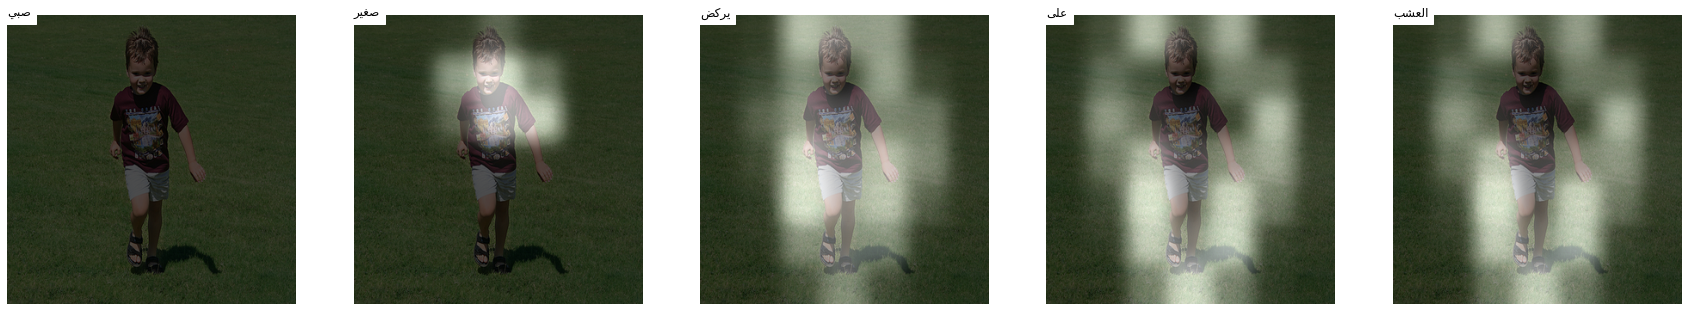

In [9]:
alphas, seq, all_caps = caption_image(img_path)
print(all_caps)
visualize_att(img_path, seq, alphas)

100%|██████████| 24000/24000 [00:00<00:00, 203175.49it/s]


Loaded Checkpoint!!
Last Epoch: 7
Best Bleu-4: 6.671753110127286


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:115: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


[tensor(-3.6769, grad_fn=<UnbindBackward0>), tensor(-4.7640, grad_fn=<UnbindBackward0>), tensor(-5.2370, grad_fn=<UnbindBackward0>)]
['صبي يقفز في الماء', 'رجل يقفز في الماء', 'صبي يقفز من الماء']


100%|██████████| 24000/24000 [00:00<00:00, 311382.11it/s]


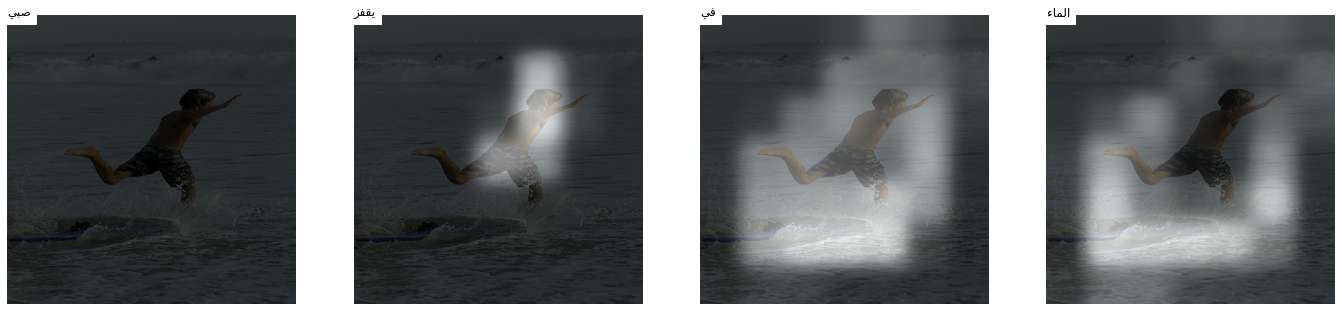

In [10]:
# upload the image from the "files sidebar"
img_path = '/content/1308617539.jpg'

alphas, seq, all_caps = caption_image(img_path)
print(all_caps)
visualize_att(img_path, seq, alphas)

100%|██████████| 24000/24000 [00:00<00:00, 51248.54it/s]


Loaded Checkpoint!!
Last Epoch: 7
Best Bleu-4: 6.671753110127286


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:115: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


[tensor(-7.6055, grad_fn=<UnbindBackward0>), tensor(-9.1549, grad_fn=<UnbindBackward0>), tensor(-13.0455, grad_fn=<UnbindBackward0>)]
['فتاة صغيرة على الترامبولين', 'صبي صغير يقفز على الترامبولين', 'صبي صغير يقفز على الترامبولين في الهواء']


100%|██████████| 24000/24000 [00:00<00:00, 299342.80it/s]


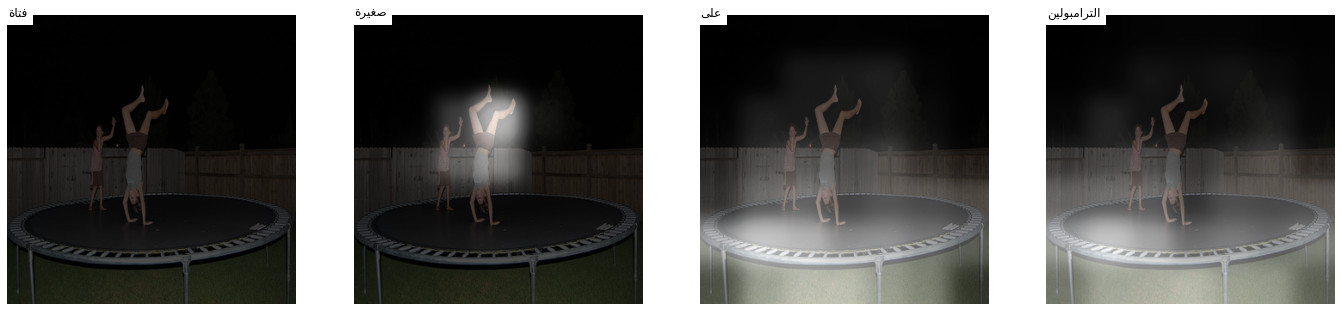

In [11]:
# upload the image from the "files sidebar"
img_path = '/content/1309330801.jpg'

alphas, seq, all_caps = caption_image(img_path)
print(all_caps)
visualize_att(img_path, seq, alphas)

100%|██████████| 24000/24000 [00:00<00:00, 121633.23it/s]


Loaded Checkpoint!!
Last Epoch: 7
Best Bleu-4: 6.671753110127286


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:115: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


[tensor(-6.9818, grad_fn=<UnbindBackward0>), tensor(-7.0413, grad_fn=<UnbindBackward0>), tensor(-9.5535, grad_fn=<UnbindBackward0>)]
['صبي صغير يلعب في العشب', 'صبي صغير يلعب كرة القدم', 'صبي صغير يلعب كرة القدم في العشب']


100%|██████████| 24000/24000 [00:00<00:00, 299035.12it/s]


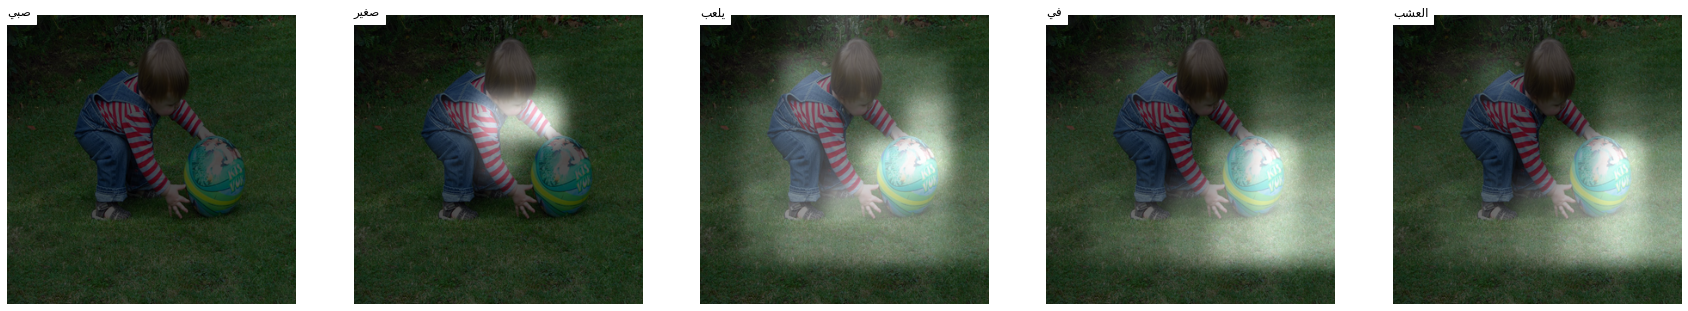

In [12]:
# upload the image from the "files sidebar"
img_path = '/content/boy-in-blue-and-red-striped-long-sleeve-shirt-playing-with-yellow-and-green-ball-on-on-on-on-on.jpg'

alphas, seq, all_caps = caption_image(img_path)
print(all_caps)
visualize_att(img_path, seq, alphas)

100%|██████████| 24000/24000 [00:00<00:00, 95973.09it/s]


Loaded Checkpoint!!
Last Epoch: 7
Best Bleu-4: 6.671753110127286


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:115: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


[tensor(-9.6167, grad_fn=<UnbindBackward0>), tensor(-10.1450, grad_fn=<UnbindBackward0>), tensor(-12.0116, grad_fn=<UnbindBackward0>)]
['مجموعة من الناس يجلسون على مقعد', 'مجموعة من الناس يجلسون على الأرض', 'مجموعة من الناس يجلسون على مقعد في الحديقة']


100%|██████████| 24000/24000 [00:00<00:00, 303202.70it/s]


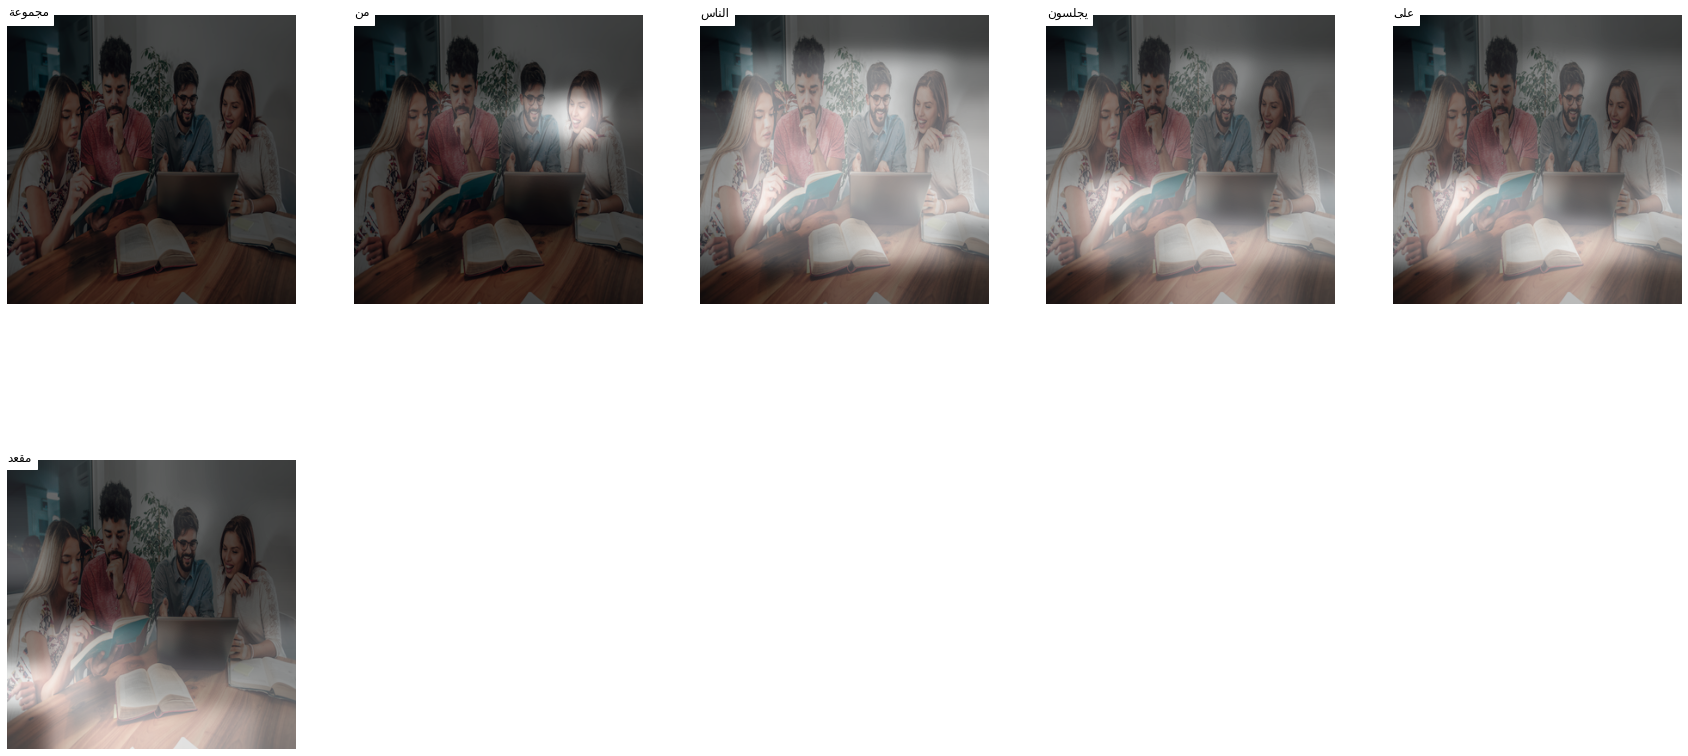

In [13]:
# upload the image from the "files sidebar"
img_path = '/content/Study-Group-web.jpeg'

alphas, seq, all_caps = caption_image(img_path)
print(all_caps)
visualize_att(img_path, seq, alphas)

100%|██████████| 24000/24000 [00:00<00:00, 270650.46it/s]


Loaded Checkpoint!!
Last Epoch: 7
Best Bleu-4: 6.671753110127286


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:115: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


[tensor(-7.9140, grad_fn=<UnbindBackward0>), tensor(-8.5726, grad_fn=<UnbindBackward0>), tensor(-9.9374, grad_fn=<UnbindBackward0>)]
['صبي صغير يلعب مع كرة التنس', 'صبي صغير يلعب مع كرة في فمه', 'صبي صغير يلعب مع كرة التنس في فمه']


100%|██████████| 24000/24000 [00:00<00:00, 274658.11it/s]


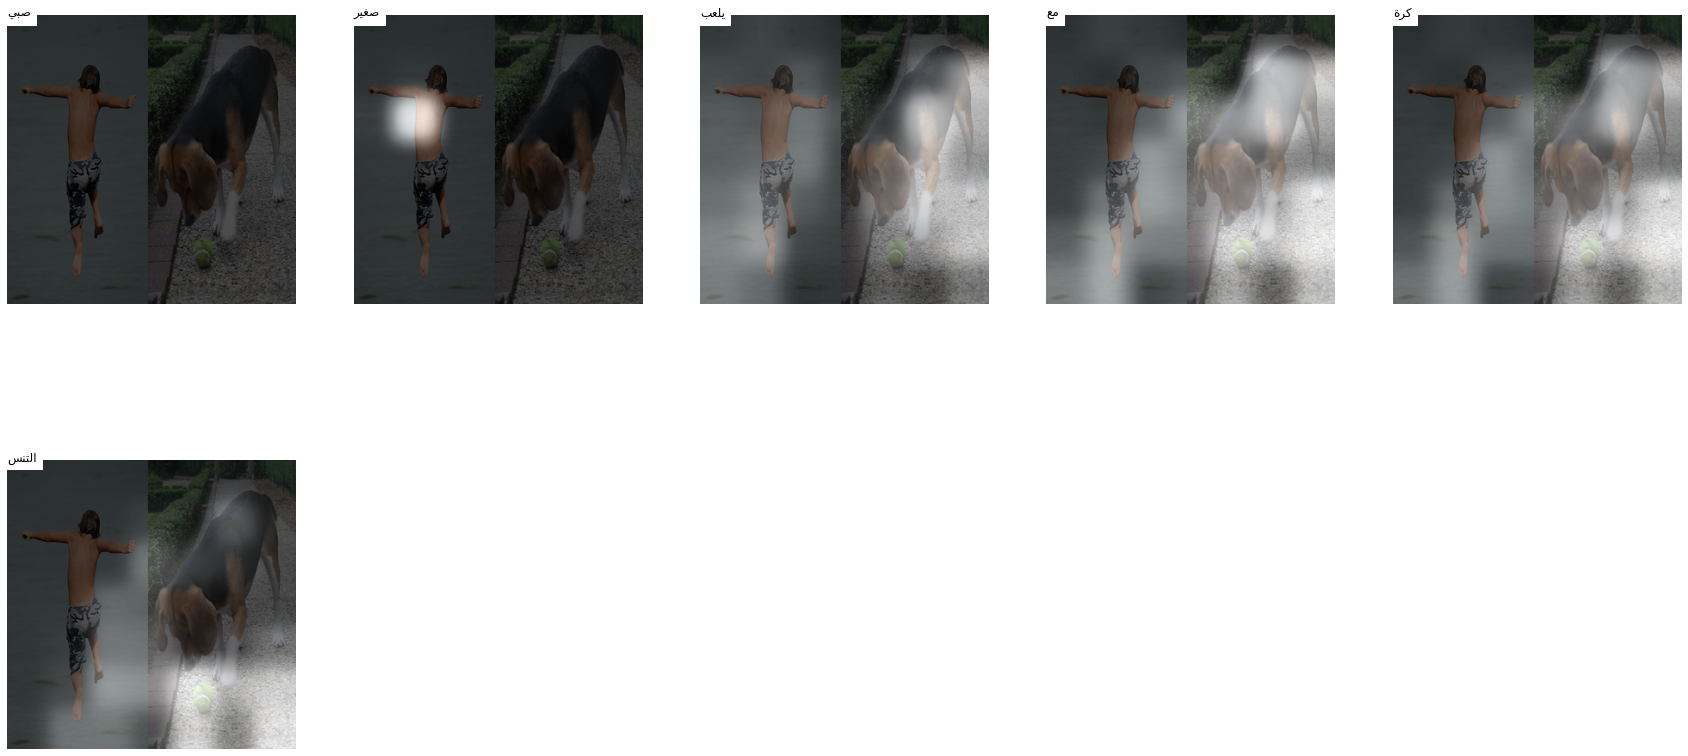

In [ ]:
# upload the image from the "files sidebar"
img_path = '/content/m6.png'

alphas, seq, all_caps = caption_image(img_path)
print(all_caps)
visualize_att(img_path, seq, alphas)

100%|██████████| 24000/24000 [00:00<00:00, 104278.20it/s]


Loaded Checkpoint!!
Last Epoch: 7
Best Bleu-4: 6.671753110127286


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:115: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


[tensor(-8.5107, grad_fn=<UnbindBackward0>), tensor(-8.6238, grad_fn=<UnbindBackward0>), tensor(-9.3279, grad_fn=<UnbindBackward0>)]
['مجموعة من الناس يقفون في حقل', 'مجموعة من الناس يجلسون في حقل', 'مجموعة من الناس يقفون في حقل عشبي']


100%|██████████| 24000/24000 [00:00<00:00, 255994.79it/s]


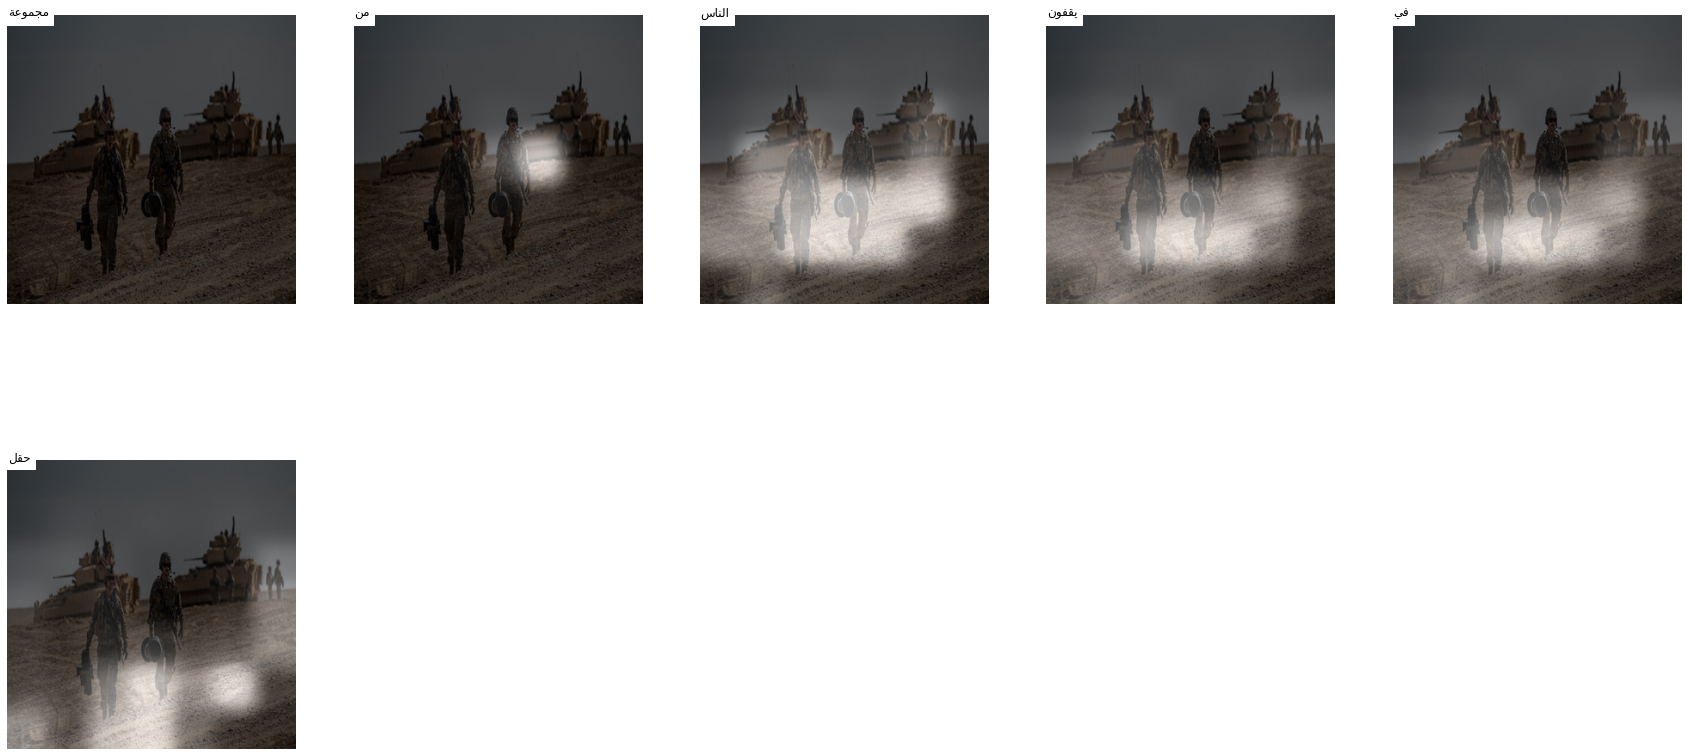

In [14]:
# upload the image from the "files sidebar"
img_path = '/content/GettyImages-1239496481.jpg'

alphas, seq, all_caps = caption_image(img_path)
print(all_caps)
visualize_att(img_path, seq, alphas)

100%|██████████| 24000/24000 [00:00<00:00, 115007.23it/s]


Loaded Checkpoint!!
Last Epoch: 7
Best Bleu-4: 6.671753110127286


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:115: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


[tensor(-9.3889, grad_fn=<UnbindBackward0>), tensor(-13.7075, grad_fn=<UnbindBackward0>), tensor(-17.4812, grad_fn=<UnbindBackward0>)]
['رجل يقف على صخرة', 'رجل في قميص أزرق يقف على صخرة', 'رجل في قميص أزرق يقف على صخرة على الشاطئ']


100%|██████████| 24000/24000 [00:00<00:00, 292259.69it/s]


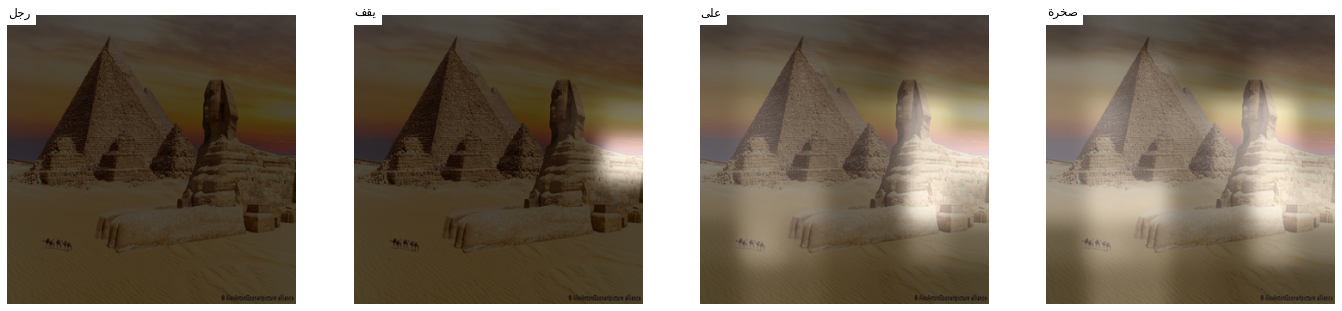

In [16]:
# upload the image from the "files sidebar"
img_path = '/content/60495947_303.jpg'

alphas, seq, all_caps = caption_image(img_path)
print(all_caps)
visualize_att(img_path, seq, alphas)

100%|██████████| 24000/24000 [00:00<00:00, 53762.21it/s]


Loaded Checkpoint!!
Last Epoch: 7
Best Bleu-4: 6.671753110127286


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:115: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


[tensor(-7.1368, grad_fn=<UnbindBackward0>), tensor(-8.6126, grad_fn=<UnbindBackward0>), tensor(-8.6341, grad_fn=<UnbindBackward0>)]
['مجموعة من الناس في الشارع', 'مجموعة من الناس في شارع المدينة', 'مجموعة من الناس يركبون في الشارع']


100%|██████████| 24000/24000 [00:00<00:00, 295301.60it/s]


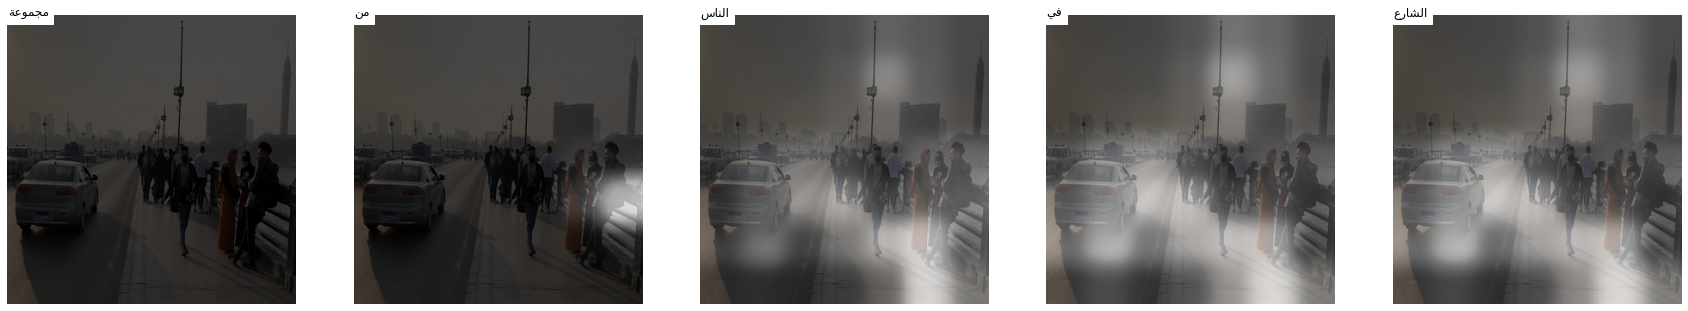

In [18]:
# upload the image from the "files sidebar"
img_path = '/content/b3ae5263-b20f-40a8-aec8-0c307ea40f3d.jpeg'

alphas, seq, all_caps = caption_image(img_path)
print(all_caps)
visualize_att(img_path, seq, alphas)

100%|██████████| 24000/24000 [00:00<00:00, 276178.01it/s]


Loaded Checkpoint!!
Last Epoch: 7
Best Bleu-4: 6.671753110127286


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:115: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


[tensor(-6.6087, grad_fn=<UnbindBackward0>), tensor(-6.6664, grad_fn=<UnbindBackward0>), tensor(-8.2938, grad_fn=<UnbindBackward0>)]
['مجموعة من الناس يسيرون في الشارع', 'مجموعة من الناس يقفون في الشارع', 'مجموعة من الناس يسيرون على الرصيف']


100%|██████████| 24000/24000 [00:00<00:00, 243784.02it/s]


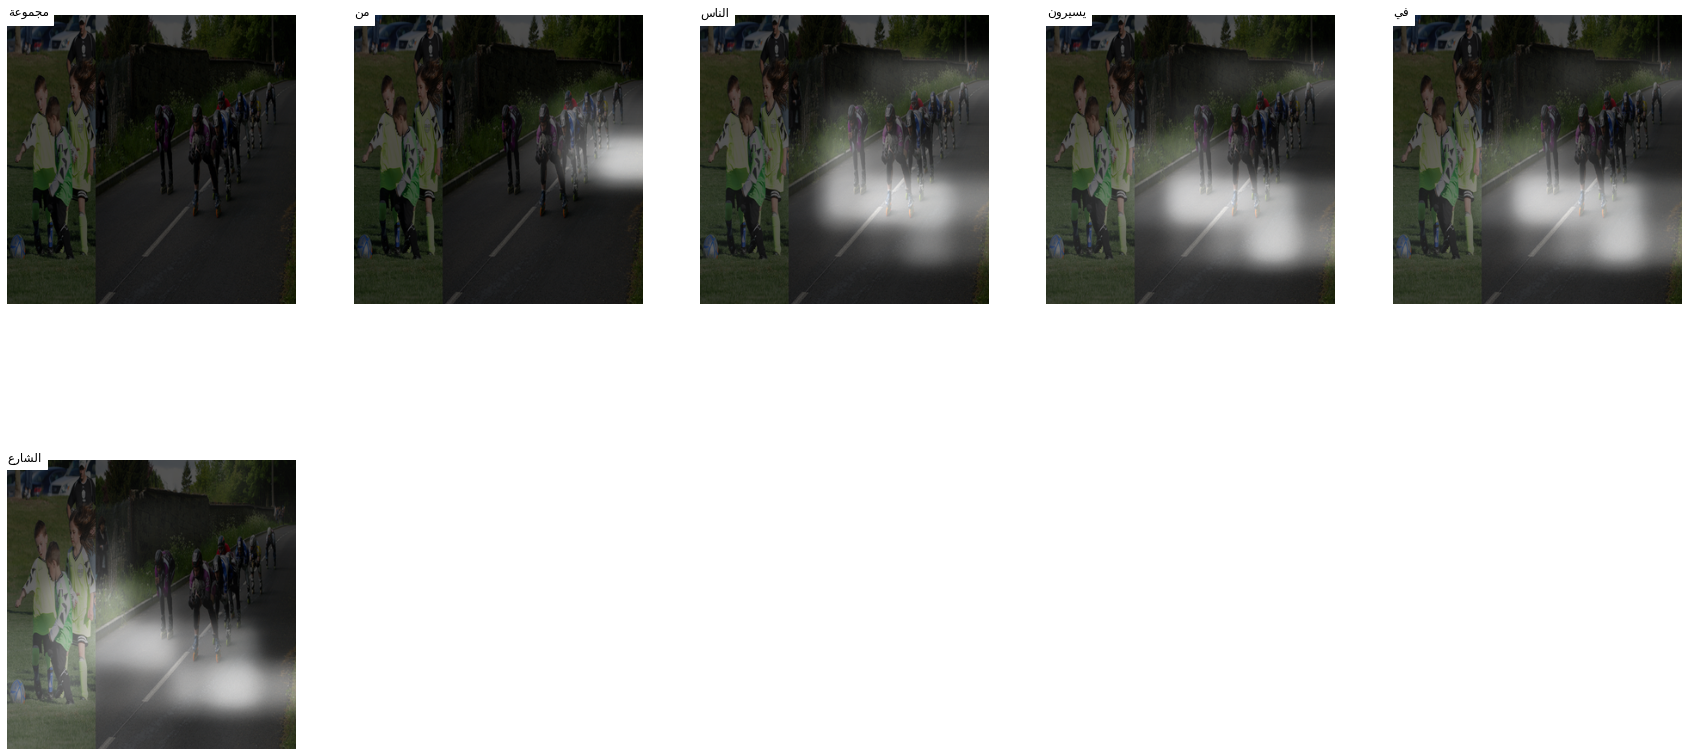

In [ ]:
# upload the image from the "files sidebar"
img_path = '/content/m10.png'

alphas, seq, all_caps = caption_image(img_path)
print(all_caps)
visualize_att(img_path, seq, alphas)

100%|██████████| 24000/24000 [00:00<00:00, 262088.03it/s]


Loaded Checkpoint!!
Last Epoch: 7
Best Bleu-4: 6.671753110127286


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:115: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


[tensor(-8.0196, grad_fn=<UnbindBackward0>), tensor(-9.1441, grad_fn=<UnbindBackward0>), tensor(-12.2498, grad_fn=<UnbindBackward0>)]
['مجموعة من الأطفال يلعبون كرة القدم', 'مجموعة من الأطفال الصغار يلعبون كرة القدم', 'مجموعة من الأطفال الصغار يلعبون كرة القدم في حقل']


100%|██████████| 24000/24000 [00:00<00:00, 292780.76it/s]


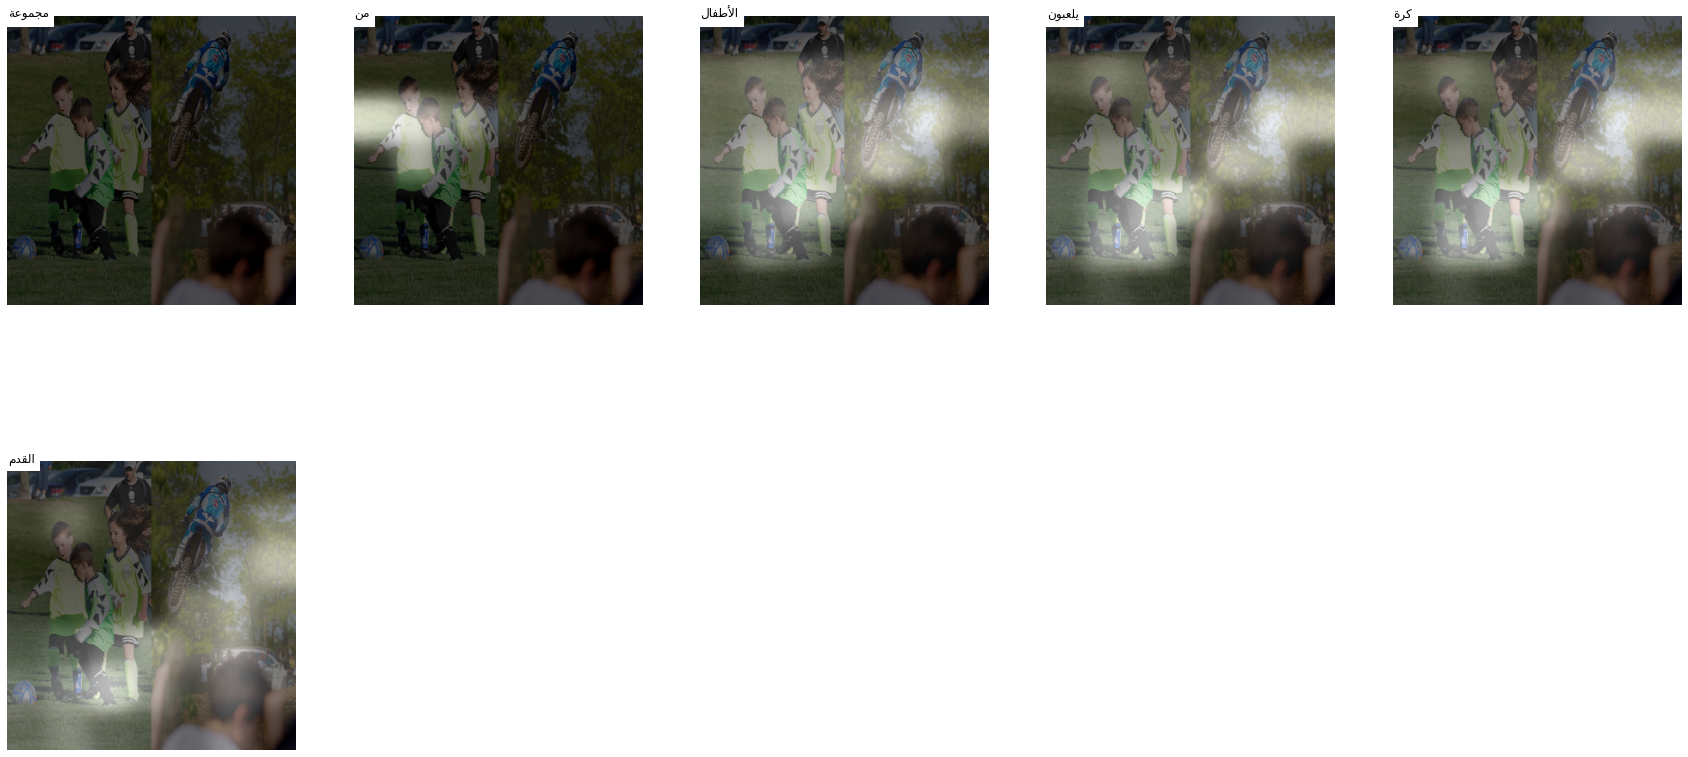

In [ ]:
# upload the image from the "files sidebar"
img_path = '/content/m11.png'

alphas, seq, all_caps = caption_image(img_path)
print(all_caps)
visualize_att(img_path, seq, alphas)

100%|██████████| 24000/24000 [00:00<00:00, 150337.52it/s]


Loaded Checkpoint!!
Last Epoch: 7
Best Bleu-4: 6.671753110127286


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:115: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


[tensor(-6.4989, grad_fn=<UnbindBackward0>), tensor(-7.2479, grad_fn=<UnbindBackward0>), tensor(-7.2503, grad_fn=<UnbindBackward0>)]
['اثنين من الكلاب يلعبون في العشب', 'اثنين من الكلاب تلعب في العشب', 'اثنين من الكلاب يلعبون في حقل']


100%|██████████| 24000/24000 [00:00<00:00, 295892.72it/s]


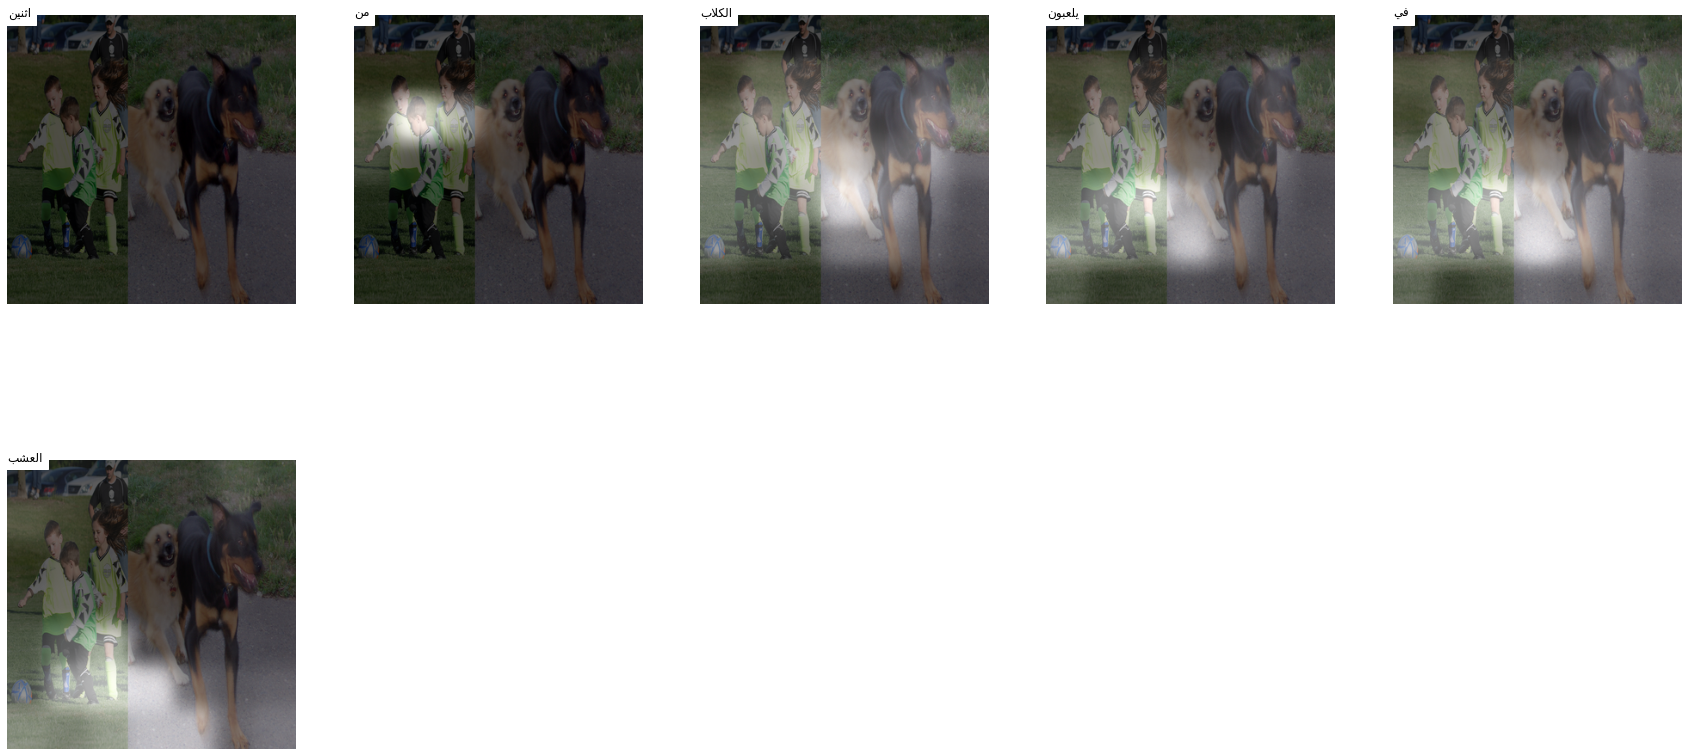

In [ ]:
# upload the image from the "files sidebar"
img_path = '/content/m12.png'

alphas, seq, all_caps = caption_image(img_path)
print(all_caps)
visualize_att(img_path, seq, alphas)

100%|██████████| 24000/24000 [00:00<00:00, 285688.77it/s]


Loaded Checkpoint!!
Last Epoch: 7
Best Bleu-4: 6.671753110127286


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:115: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


[tensor(-9.8268, grad_fn=<UnbindBackward0>), tensor(-9.9820, grad_fn=<UnbindBackward0>), tensor(-10.4059, grad_fn=<UnbindBackward0>)]
['اثنين من الكلاب يلعبون في الهواء', 'اثنين من الكلاب يلعبون على الأرض', 'اثنين من الكلاب تلعب في الهواء']


100%|██████████| 24000/24000 [00:00<00:00, 264166.52it/s]


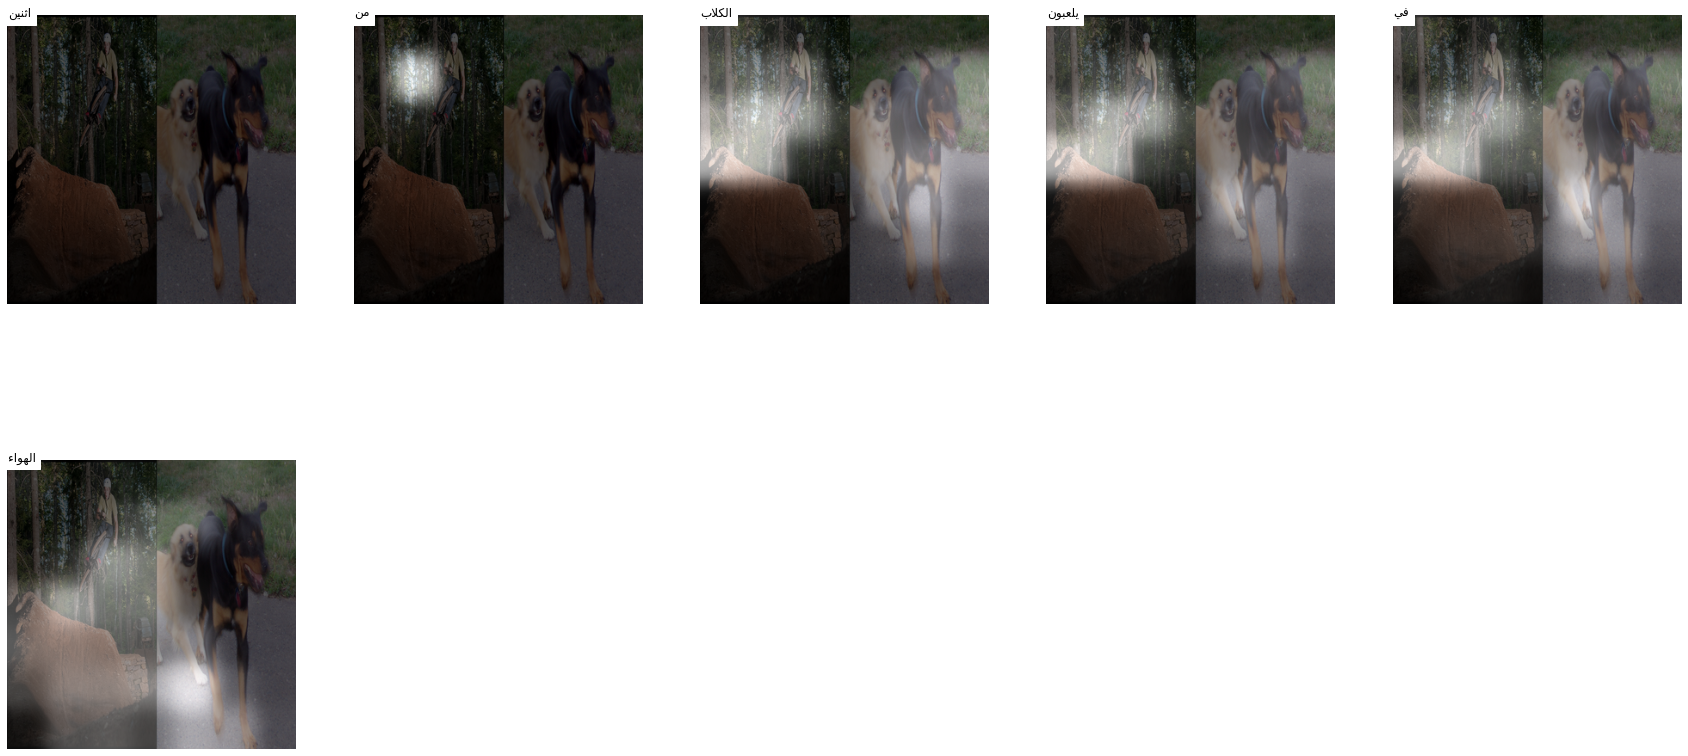

In [ ]:
# upload the image from the "files sidebar"
img_path = '/content/imgonline-com-ua-twotoone-tjVqXr0Hq07.png'

alphas, seq, all_caps = caption_image(img_path)
print(all_caps)
visualize_att(img_path, seq, alphas)